In [1]:
import sys, os, distutils.core
import torch, detectron2

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
f'Cuda enabled Torch: {torch.cuda.is_available()}'

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:38:46_Pacific_Standard_Time_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0
torch:  2.6 ; cuda:  cu126
detectron2: 0.6


'Cuda enabled Torch: True'

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
from PIL import Image
import requests
import yaml

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, r"F:\Work\UNI\ResProj\TR-Y4-Project\training_imgs\13_02_img_lbls.json", r"F:\Work\UNI\ResProj\TR-Y4-Project\training_imgs\ims")
register_coco_instances("my_dataset_val", {}, r"F:\Work\UNI\ResProj\TR-Y4-Project\training_imgs\13_02_img_lbls.json", r"F:\Work\UNI\ResProj\TR-Y4-Project\training_imgs\13_02_img_lbls.json")


In [4]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[02/25 17:45:02 d2.data.datasets.coco]: Loaded 6 images in COCO format from F:\Work\UNI\ResProj\TR-Y4-Project\training_imgs\13_02_img_lbls.json
[02/25 17:45:02 d2.data.datasets.coco]: Loaded 6 images in COCO format from F:\Work\UNI\ResProj\TR-Y4-Project\training_imgs\13_02_img_lbls.json


In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here

cfg.OUTPUT_DIR = r"F:\Work\UNI\ResProj\TR-Y4-Project\Model_v2"

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/25 17:46:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[02/25 17:46:43 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\Toumai\anaconda3\envs\Res\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/25 17:46:55 d2.utils.events]:  eta: 0:01:11  iter: 19  total_loss: 6.428  loss_cls: 1.038  loss_box_reg: 0.6327  loss_mask: 0.6967  loss_rpn_cls: 3.523  loss_rpn_loc: 0.5679    time: 0.2615  last_time: 0.2989  data_time: 0.3089  last_data_time: 0.0585   lr: 1.6068e-05  max_mem: 2073M
[02/25 17:47:00 d2.utils.events]:  eta: 0:01:06  iter: 39  total_loss: 2.836  loss_cls: 0.9506  loss_box_reg: 0.6817  loss_mask: 0.6777  loss_rpn_cls: 0.1715  loss_rpn_loc: 0.3917    time: 0.2595  last_time: 0.2292  data_time: 0.0093  last_data_time: 0.0011   lr: 3.2718e-05  max_mem: 2248M
[02/25 17:47:06 d2.utils.events]:  eta: 0:01:01  iter: 59  total_loss: 2.593  loss_cls: 0.7533  loss_box_reg: 0.6926  loss_mask: 0.6426  loss_rpn_cls: 0.1533  loss_rpn_loc: 0.3291    time: 0.2585  last_time: 0.2651  data_time: 0.0107  last_data_time: 0.0013   lr: 4.9367e-05  max_mem: 2248M
[02/25 17:47:12 d2.utils.events]:  eta: 0:00:56  iter: 79  total_loss: 2.363  loss_cls: 0.6743  loss_box_reg: 0.7021  loss_mask: 

In [8]:
cfg.OUTPUT_DIR = r"F:\Work\UNI\ResProj\TR-Y4-Project\Model_v2"
# Save the configuration to a config.yaml file
config_yaml_path = cfg.OUTPUT_DIR+"/config.yaml"
#config_yaml_path = "/content/gdrive/MyDrive/Colab_Notebook_3/Detectron2/Project_Jason_1/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [9]:
print(torch.cuda.is_available())

True


In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)

[02/25 17:50:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from F:\Work\UNI\ResProj\TR-Y4-Project\Model_v2\model_final.pth ...


Segmenting image 1 / 1

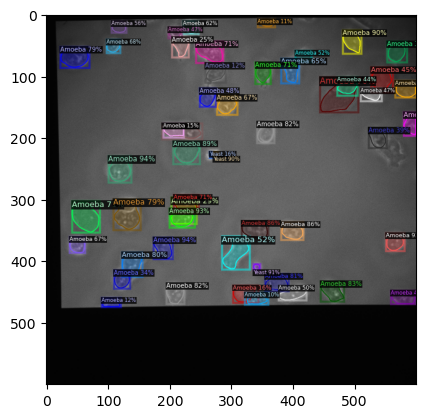

In [12]:
from detectron2.utils.visualizer import ColorMode

num_images =1
input_images_directory = r'F:\Work\UNI\ResProj\TR-Y4-Project\Research\PHASE'

for i, image_filename in enumerate(os.listdir(input_images_directory)[:num_images]):
    sys.stdout.write(f'\rSegmenting image {i+1} / {num_images}')
    sys.stdout.flush()
    image_path = os.path.join(input_images_directory, image_filename)
    im = cv2.imread(image_path)

    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW 
    )
   
    out = v.draw_instance_predictions(outputs["instances"].to('cpu'))
    plt.imshow(out.get_image()[:, :, ::-1])
    #plt.savefig('test_seg.png')